# Linear Regression Netural Network

In [38]:
%matplotlib inline
import math
import time
import numpy as np
import torch
import random
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt

In [32]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

## Vector acceleration

In [33]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]

print(a, b, c)
f'{timer.stop():.5f} sec'


tensor([1., 1., 1.,  ..., 1., 1., 1.]) tensor([1., 1., 1.,  ..., 1., 1., 1.]) tensor([2., 2., 2.,  ..., 2., 2., 2.])


'0.13272 sec'

In [34]:
timer.start()
d = a + b
print(a,b,d)
f'{timer.stop():.5f} sec'


tensor([1., 1., 1.,  ..., 1., 1., 1.]) tensor([1., 1., 1.,  ..., 1., 1., 1.]) tensor([2., 2., 2.,  ..., 2., 2., 2.])


'0.00565 sec'

## normal distribution

In [35]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)


In [36]:
def use_svg_display(): #@save
    """svg"""
    backend_inline.set_matplotlib_formats('svg')

## figure size
def set_figsize(figsize=(3.5, 2.5)): #@save
    """matplotlib figuresize"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

## get the figure axis
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set matplotlib Axis"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点图形"""
    if legend is None:
        legend = []
    
    set_figsize(figsize)
    axes = axes if axes else plt.gca()
    
    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    
    if len(X) != len(Y):
        X = X * len(Y)
        axes.cla()
    
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    
    return axes

def has_one_axis(X):
    """判断数据是否有一个轴"""
    return hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list) and not hasattr(X[0], "__len__")
    

<Axes: xlabel='x', ylabel='p(x)'>

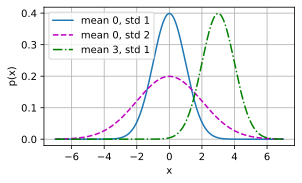

In [37]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)
# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5), legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])


##  LRNN Start

In [39]:
# dataset
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [40]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [41]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.1803, -2.2950]) 
label: tensor([9.6448])


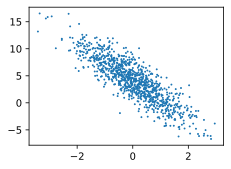

In [42]:
set_figsize()
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);


In [45]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # Some Sample are random
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
        indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [46]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.2570,  0.3058],
        [-0.8497,  0.6436],
        [-0.7381, -1.2801],
        [ 1.4672,  0.1840],
        [-2.8994,  0.3120],
        [-0.8703,  0.1327],
        [ 0.1481, -1.3841],
        [ 0.5214,  0.4361],
        [-0.7131,  1.4418],
        [-0.1436, -1.2345]]) 
 tensor([[ 0.6433],
        [ 0.3106],
        [ 7.0839],
        [ 6.4895],
        [-2.6546],
        [ 2.0146],
        [ 9.1955],
        [ 3.7502],
        [-2.1269],
        [ 8.1074]])


### Initlize Model 

In [47]:
# mean = 0 , std = 0.01
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[ 0.0045],
         [-0.0056]], requires_grad=True),
 tensor([0.], requires_grad=True))

### def Model 

In [48]:
def linreg(X, w, b): #@save
    """LR"""
    return torch.matmul(X, w) + b

### def squard_loss

In [49]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### def and improve aglorism 

In [51]:
def sgd(params, lr, batch_size): #@save
    """small batch_size grident deduction"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


### Train

In [52]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041778
epoch 2, loss 0.000166
epoch 3, loss 0.000049


In [53]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0009, -0.0010], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)
